In [23]:
import os
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras import  models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD
from Methods import load_images, plot_sample_images, plot_model_metrics, plot_images_with_predictions, plot_confusion_matrix, plot_mismatched_images

# Hybrid Model - Regression and CNN

This notebook is dedicated to documenting the training process of our hybrid model which combines a CNN and a regression model. The CNN is used to classify the players in the image, while the regression model is used to estimate the distance of the player from the camera. The model is trained on a dataset of images game object with their distances from the camera labelled. The model is trained using the Keras library.



In [9]:
image_dir = os.path.dirname(os.getcwd())+"\\Screenshots\\with_distance_labels\\"
filenames = os.listdir(image_dir)
labels = [x.split("_")[0] for x in filenames]
img = [imread(image_dir + x) for x in filenames]
distances = pd.to_numeric([x.split("_")[1] for x in filenames], errors='coerce')
data = pd.DataFrame({"filename": filenames, "label": labels, "img": img, "distance": distances})


data = data.reset_index()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1232 non-null   int64  
 1   filename  1232 non-null   object 
 2   label     1232 non-null   object 
 3   img       1232 non-null   object 
 4   distance  1232 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 48.2+ KB


In [10]:
#Splitting the data into training and testing
train_df, test_df = train_test_split(data, test_size=0.3)

# Datagen for training data. Augment the data by rotating, shifting, flipping, to make the model more robust and less prone to overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory=image_dir,
    target_size=(64, 64),
    x_col='filename',
    y_col='label',
    batch_size=32,
    class_mode='categorical'  # or 'categorical' based on your problem
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode= "categorical",  # or 'categorical'
    shuffle=False
)

# Creating a new generator that also yields distance
def combined_generator(generator, df):
    while True:
        # Get next batch from the original generator
        x, y = next(generator)
        # Get indices of the dataframe rows used in this batch (use filenames to match)
        _filenames = generator.filenames[generator.batch_index - 1:generator.batch_index - 1 + generator.batch_size]
        # Extract distances using the filenames to match indices
        _distances = df[df['filename'].isin(_filenames)]['distance'].values
        # Ensure the distance array matches the batch size, especially for the last batch
        _distances = np.resize(_distances, (x.shape[0],))
        # Yield the image batch and both outputs
        yield x, (y, _distances)

# Use the new generator
train_combined_generator = combined_generator(train_generator, train_df)
test_combined_generator = combined_generator(test_generator, test_df)

Found 862 validated image filenames belonging to 5 classes.
Found 370 validated image filenames belonging to 5 classes.


In [11]:

def plot_history(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

    plt.plot(np.array(model.history['loss'])-np.array(model.history['distance_output_mse']))
    plt.plot(np.array(model.history['val_loss'])-np.array(model.history['val_distance_output_mse']))
    plt.title('Classification loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

    plt.plot(model.history['class_output_accuracy'])
    plt.plot(model.history['val_class_output_accuracy'])
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

    plt.plot(model.history['distance_output_mse'])
    plt.plot(model.history['val_distance_output_mse'])
    plt.title('Distance Accuracy (MSE)')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

# Model 1

This is the original starting point for the training process. The model is trained for 30 epochs. The learning rate is set to 0.0001. The model is not overfitting and the loss is decreasing with training. The model is a good starting point for further training.

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - class_output_accuracy: 0.1550 - distance_output_mse: 321.8573 - loss: 323.4672 - val_class_output_accuracy: 0.1595 - val_distance_output_mse: 207.6928 - val_loss: 209.1928
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - class_output_accuracy: 0.3061 - distance_output_mse: 166.2979 - loss: 167.7663 - val_class_output_accuracy: 0.3730 - val_distance_output_mse: 147.0178 - val_loss: 148.4395
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - class_output_accuracy: 0.3403 - distance_output_mse: 122.0037 - loss: 123.4483 - val_class_output_accuracy: 0.3730 - val_distance_output_mse: 118.8677 - val_loss: 120.2866
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - class_output_accuracy: 0.3168 - distance_output_mse: 95.1367 - loss: 96.5881 - val_class_output_accuracy: 0.3730 - val_distance_output_mse: 119.7983 - val_loss: 121.1847
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - class_output_accuracy: 0.3053 - distance_out

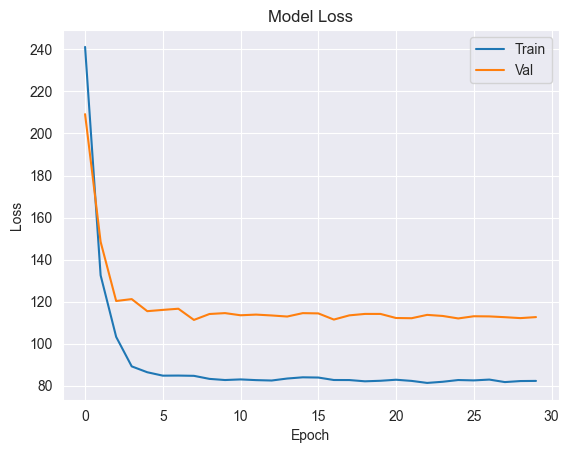

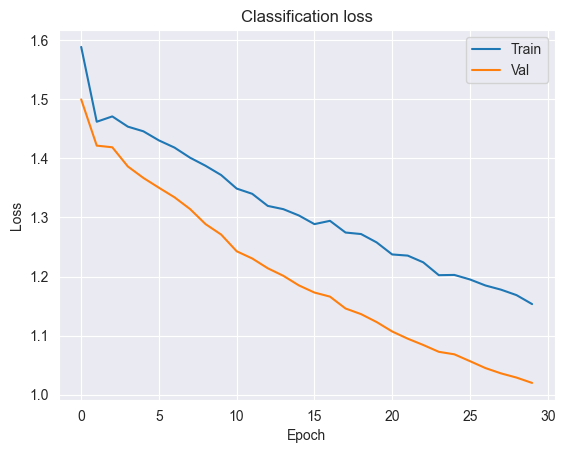

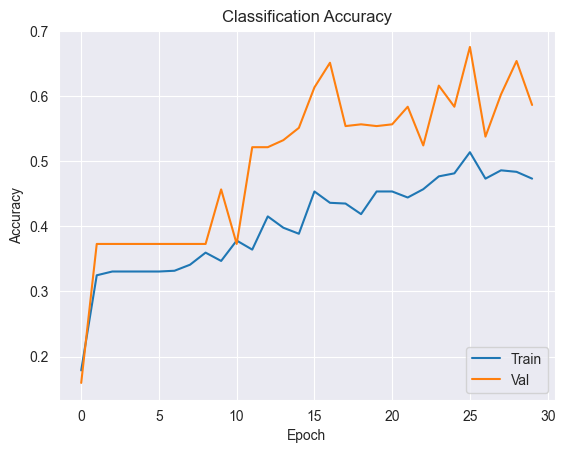

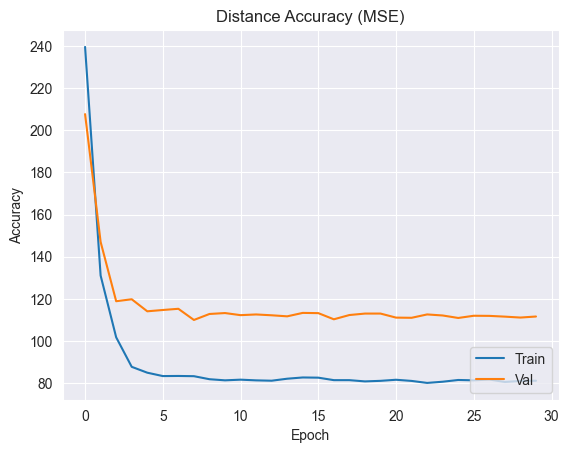

In [12]:
# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)

plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(np.array(trained_model.history['loss'])-np.array(trained_model.history['distance_output_mse']))
plt.plot(np.array(trained_model.history['val_loss'])-np.array(trained_model.history['val_distance_output_mse']))
plt.title('Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(trained_model.history['class_output_accuracy'])
plt.plot(trained_model.history['val_class_output_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

plt.plot(trained_model.history['distance_output_mse'])
plt.plot(trained_model.history['val_distance_output_mse'])
plt.title('Distance Accuracy (MSE)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)

plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(np.array(trained_model.history['loss'])-np.array(trained_model.history['distance_output_mse']))
plt.plot(np.array(trained_model.history['val_loss'])-np.array(trained_model.history['val_distance_output_mse']))
plt.title('Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(trained_model.history['class_output_accuracy'])
plt.plot(trained_model.history['val_class_output_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

plt.plot(trained_model.history['distance_output_mse'])
plt.plot(trained_model.history['val_distance_output_mse'])
plt.title('Distance Accuracy (MSE)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

# More epochs
This model has increased number of epochs to 60. This is to capture more of the plot from the earlier plot. The learning rate is set to 0.001. The model is not overfitting and the loss is decreasing with training.

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - class_output_accuracy: 0.2378 - distance_output_mse: 184.6948 - loss: 186.3164 - val_class_output_accuracy: 0.4189 - val_distance_output_mse: 106.9489 - val_loss: 108.3825
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - class_output_accuracy: 0.3491 - distance_output_mse: 78.0687 - loss: 79.5888 - val_class_output_accuracy: 0.3703 - val_distance_output_mse: 115.3715 - val_loss: 116.7634
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - class_output_accuracy: 0.3340 - distance_output_mse: 74.0082 - loss: 75.4600 - val_class_output_accuracy: 0.3865 - val_distance_output_mse: 108.3655 - val_loss: 109.6531
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - class_output_accuracy: 0.3836 - distance_output_mse: 73.5610 - loss: 74.9349 - val_class_output_accuracy: 0.4189 - val_distance_output_mse: 108.9385 - val_loss: 110.1561
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - class_output_accuracy: 0.4654 - distance_outp

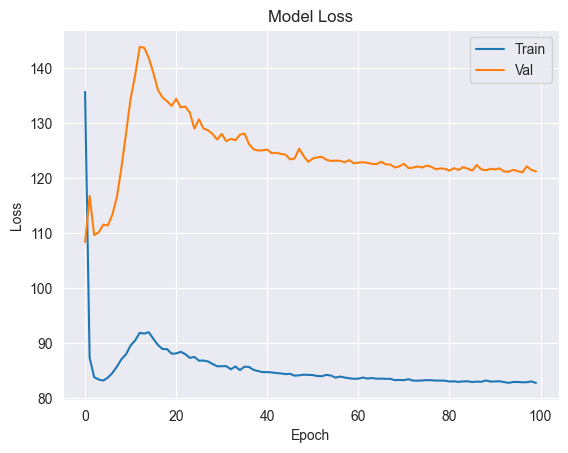

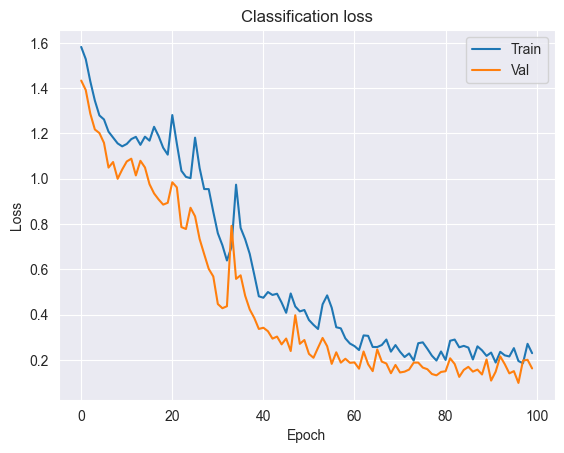

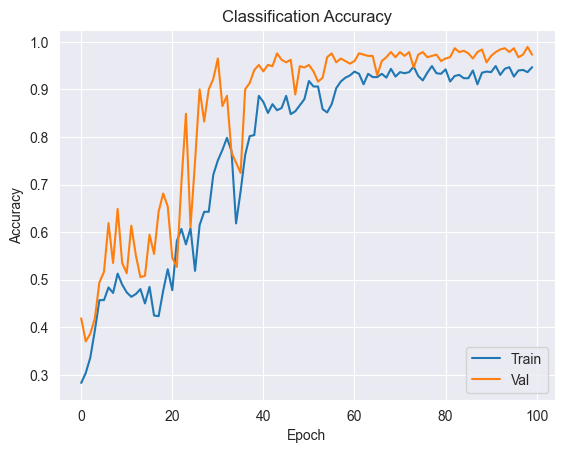

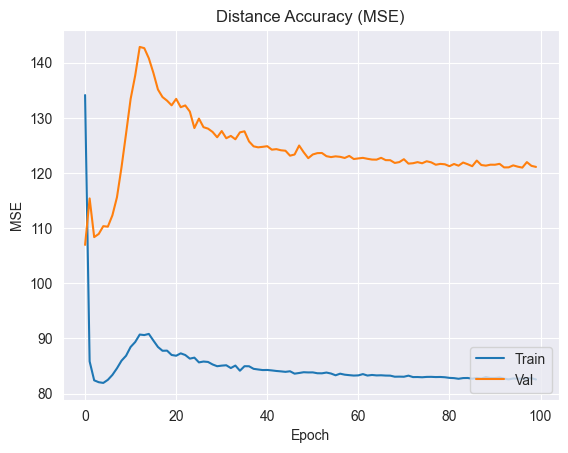

In [29]:

# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)

plot_history(trained_model)

# Model with Gradient Descent Optimizer

This model uses the Stochastic Gradient Descent optimizer instead of the Adam optimizer used in the previous models. The model is trained for 60 epochs. The learning rate is set to 0.00001. The plots are terrible therefore it was scrapped.


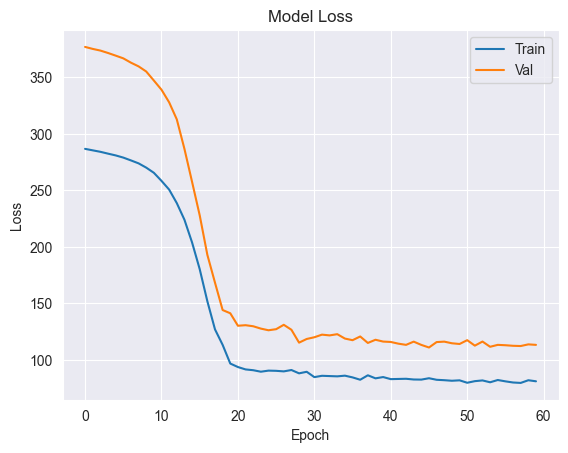

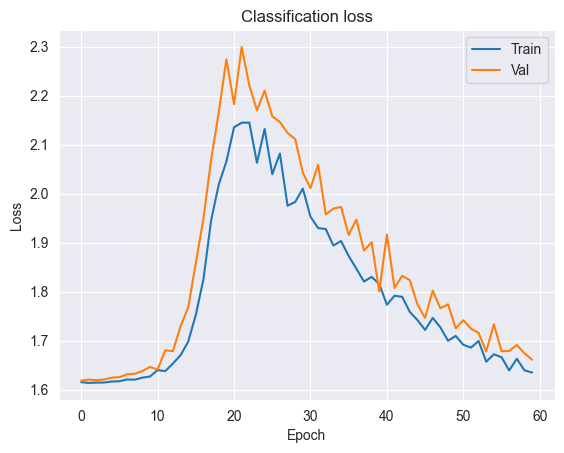

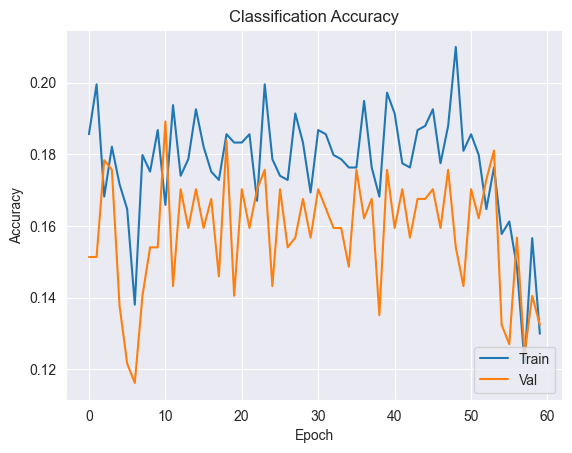

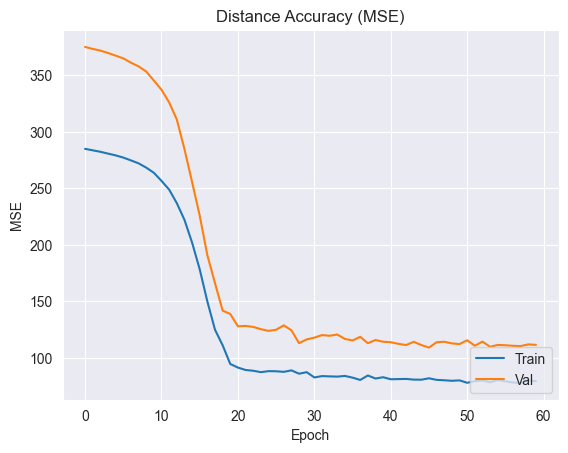

In [17]:
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=SGD(learning_rate=0.00001),
              loss={ 'distance_output': 'mse','class_output': 'categorical_crossentropy'},
              metrics={'distance_output': 'mse','class_output': 'accuracy', })

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)# If using a separate test_generator
    , verbose=0
)


plot_history(trained_model)

# More complex mode
This model has more layers and more neurons in the dense layers. The model is trained for 30 epochs. The learning rate is set to 0.00001. The loss only gets worse with training suggesting the model is complex or overfitting. The model does have absurd amount of dropout layers which could be the cause of the poor performance.

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - class_output_accuracy: 0.2226 - distance_output_mse: 308.5516 - loss: 310.1666 - val_class_output_accuracy: 0.3324 - val_distance_output_mse: 340.4772 - val_loss: 342.0873
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - class_output_accuracy: 0.2228 - distance_output_mse: 306.4346 - loss: 308.0485 - val_class_output_accuracy: 0.3432 - val_distance_output_mse: 337.1789 - val_loss: 338.7807
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - class_output_accuracy: 0.2365 - distance_output_mse: 303.2161 - loss: 304.8295 - val_class_output_accuracy: 0.2757 - val_distance_output_mse: 331.9241 - val_loss: 333.5297
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - class_output_accuracy: 0.2103 - distance_output_mse: 297.2087 - loss: 298.8289 - val_class_output_accuracy: 0.2892 - val_distance_output_mse: 322.6223 - val_loss: 324.2355
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - class_output_accuracy: 0.2455 - distance_ou

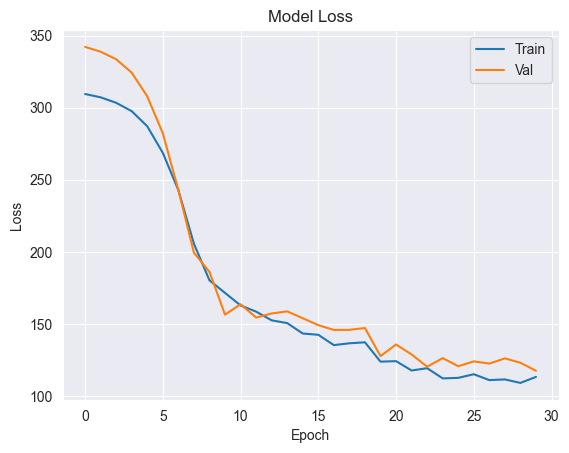

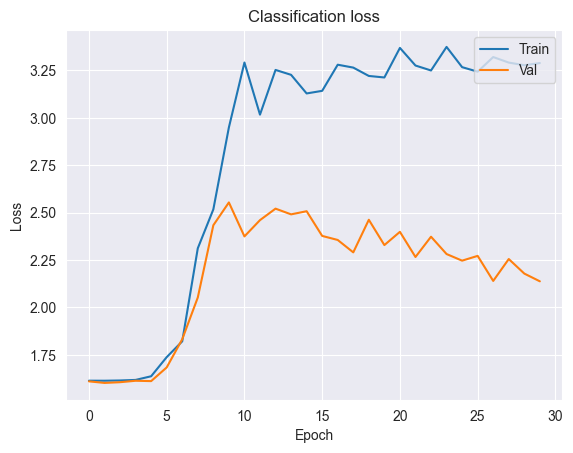

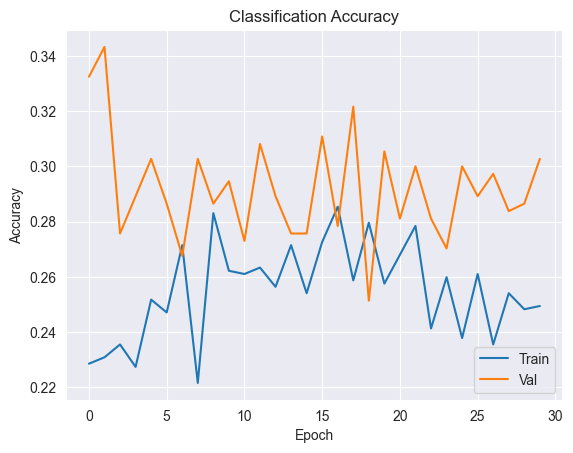

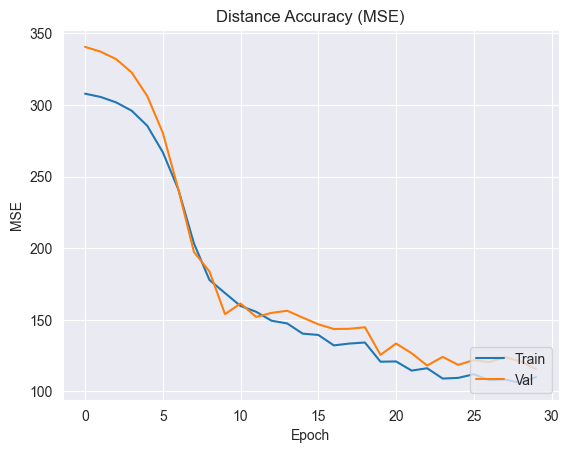

In [30]:
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Add the Dense layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss={ 'distance_output': 'mse','class_output': 'categorical_crossentropy'},
              metrics={'distance_output': 'mse','class_output': 'accuracy', })

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

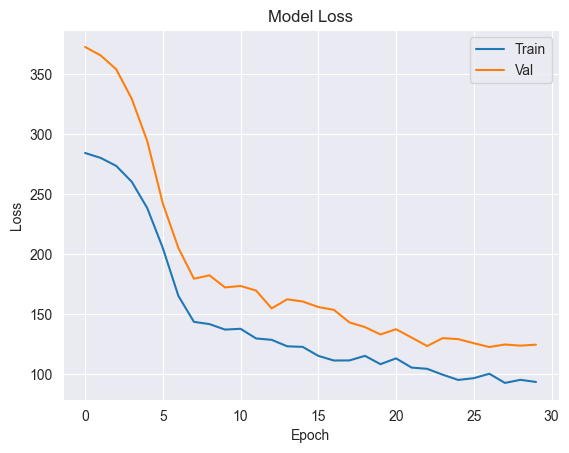

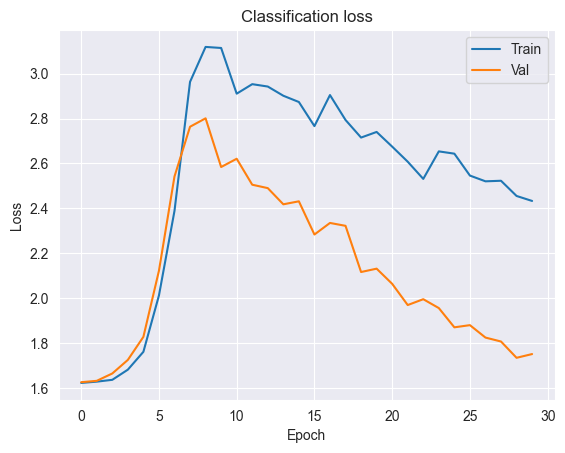

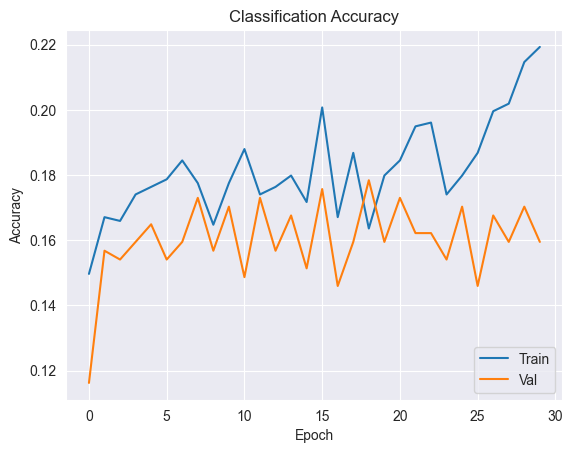

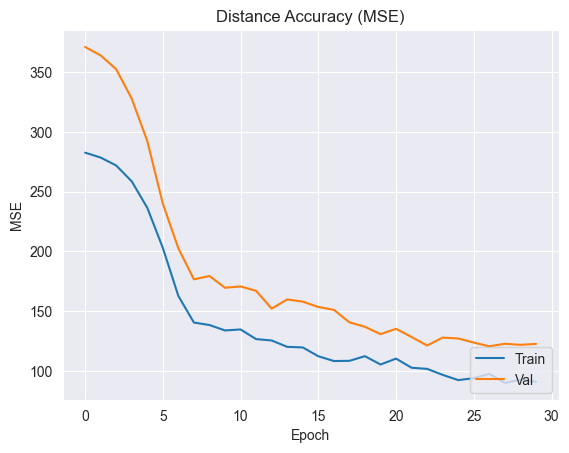

In [19]:
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Add the Dense layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss={ 'distance_output': 'mse','class_output': 'categorical_crossentropy'},
              metrics={'distance_output': 'mse','class_output': 'accuracy', })

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator),  # If using a separate test_generator
    verbose = 0
)


plot_history(trained_model)

# Model with less layers
This is the first attempt that is not overfitting. The model has less layers and less neurons in the dense layers. The model is trained for 30 epochs. The model is continously improving with training. The learning rate is set to 0.0001. The model is not overfitting and the loss is decreasing with training.

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - class_output_accuracy: 0.2365 - distance_output_mse: 268.5056 - loss: 270.1476 - val_class_output_accuracy: 0.2946 - val_distance_output_mse: 220.6695 - val_loss: 222.6220
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - class_output_accuracy: 0.3642 - distance_output_mse: 176.0358 - loss: 177.9365 - val_class_output_accuracy: 0.2811 - val_distance_output_mse: 184.6363 - val_loss: 186.6934
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - class_output_accuracy: 0.3878 - distance_output_mse: 142.2115 - loss: 143.9888 - val_class_output_accuracy: 0.2919 - val_distance_output_mse: 139.9596 - val_loss: 141.6673
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - class_output_accuracy: 0.3628 - distance_output_mse: 103.5004 - loss: 105.1269 - val_class_output_accuracy: 0.2892 - val_distance_output_mse: 121.1291 - val_loss: 122.6931
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - class_output_accuracy: 0.3690 - distance_outpu

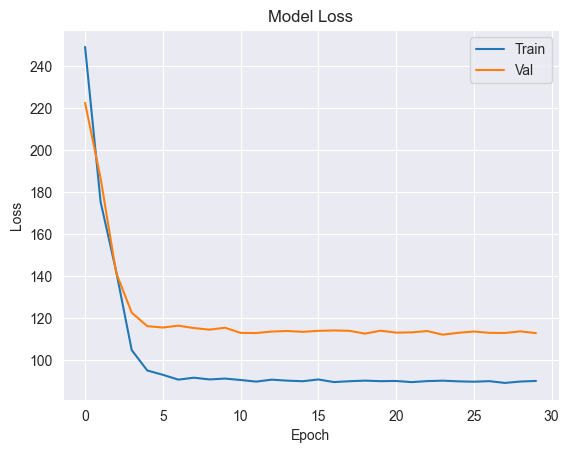

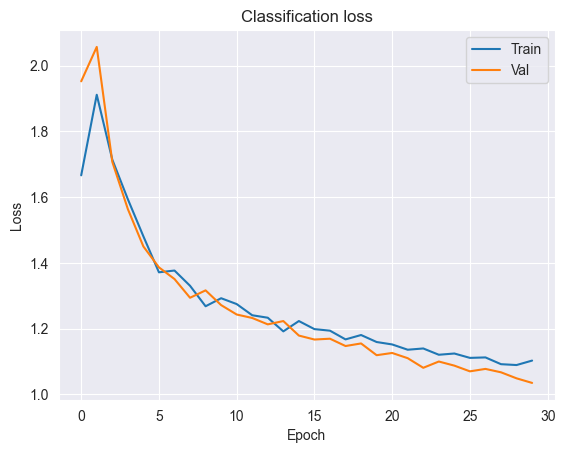

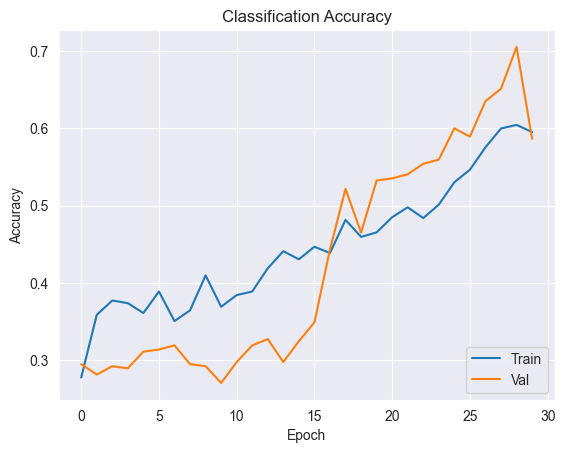

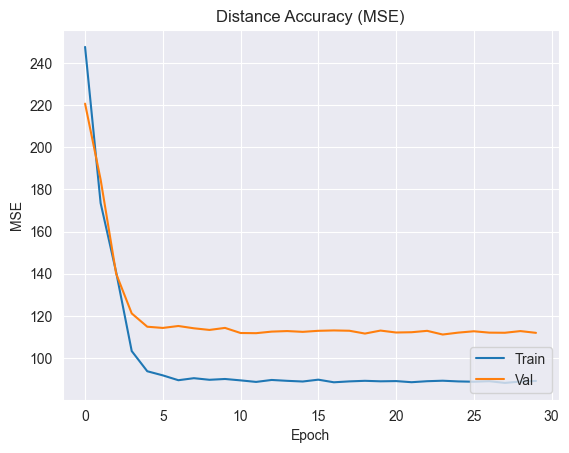

In [31]:
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(64, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - class_output_accuracy: 0.2011 - distance_output_mse: 245.7420 - loss: 247.3913 - val_class_output_accuracy: 0.2162 - val_distance_output_mse: 193.7741 - val_loss: 195.9835
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - class_output_accuracy: 0.1489 - distance_output_mse: 134.9395 - loss: 137.1825 - val_class_output_accuracy: 0.1595 - val_distance_output_mse: 129.3194 - val_loss: 131.8069
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - class_output_accuracy: 0.1711 - distance_output_mse: 98.3743 - loss: 100.6049 - val_class_output_accuracy: 0.1946 - val_distance_output_mse: 117.5812 - val_loss: 119.7364
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - class_output_accuracy: 0.2096 - distance_output_mse: 91.5149 - loss: 93.5466 - val_class_output_accuracy: 0.2622 - val_distance_output_mse: 113.2889 - val_loss: 115.1032
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - class_output_accuracy: 0.3001 - distance_output_

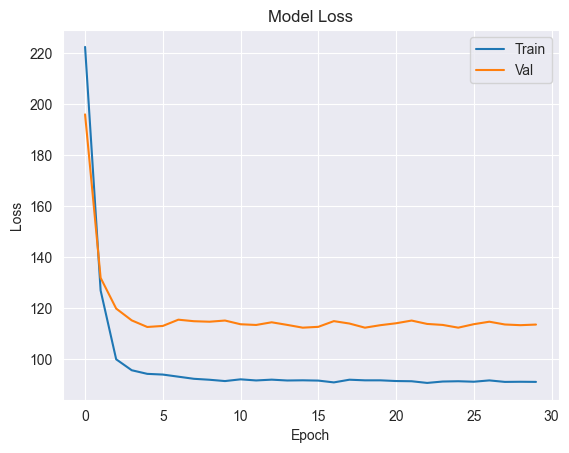

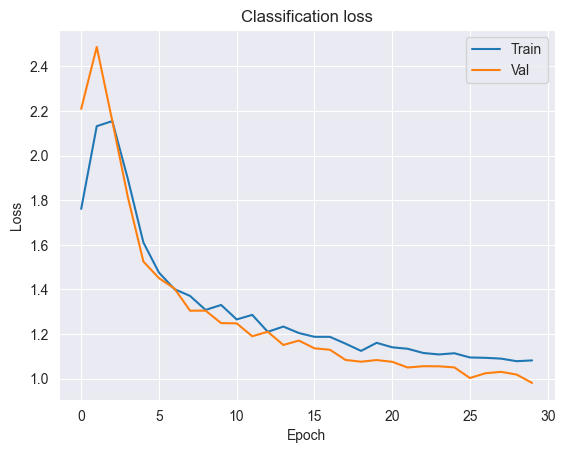

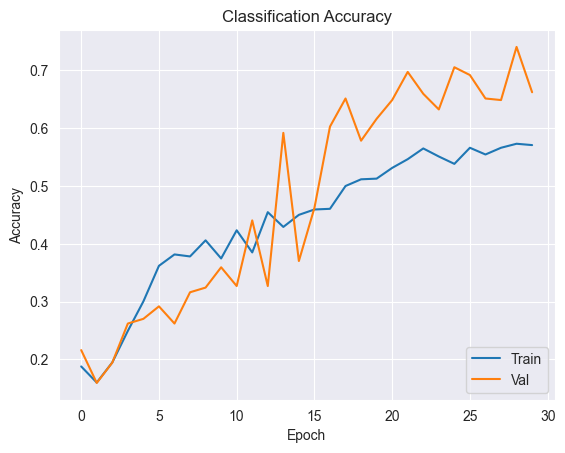

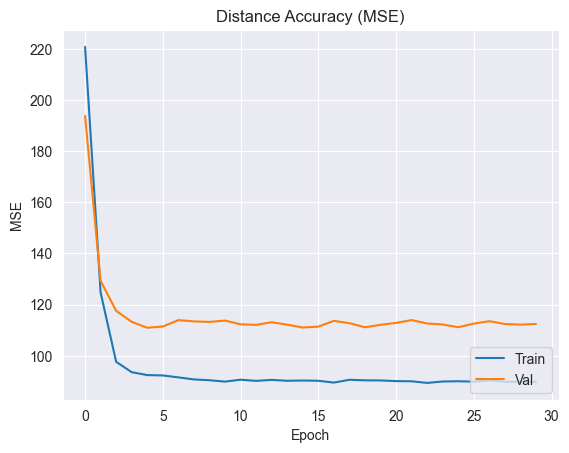

In [32]:
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(64, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - class_output_accuracy: 0.3056 - distance_output_mse: 235.3913 - loss: 236.9484 - val_class_output_accuracy: 0.3027 - val_distance_output_mse: 192.7026 - val_loss: 194.2486
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - class_output_accuracy: 0.3085 - distance_output_mse: 145.6437 - loss: 147.4344 - val_class_output_accuracy: 0.3027 - val_distance_output_mse: 128.1038 - val_loss: 129.7213
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - class_output_accuracy: 0.2917 - distance_output_mse: 93.8488 - loss: 95.9951 - val_class_output_accuracy: 0.2784 - val_distance_output_mse: 116.4392 - val_loss: 117.9998
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - class_output_accuracy: 0.3135 - distance_output_mse: 94.5492 - loss: 96.5430 - val_class_output_accuracy: 0.2811 - val_distance_output_mse: 117.0926 - val_loss: 118.5069
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - class_output_accuracy: 0.3097 - distance_output_m

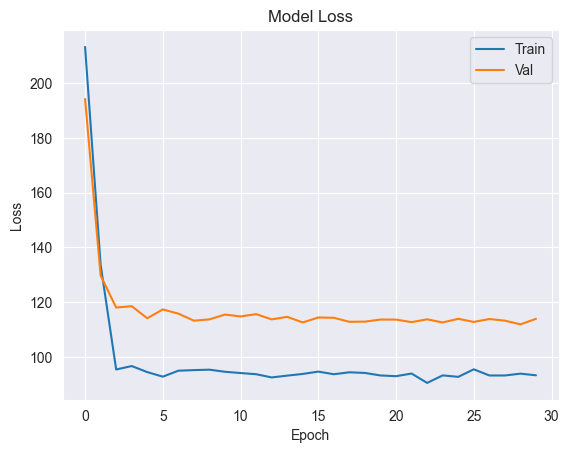

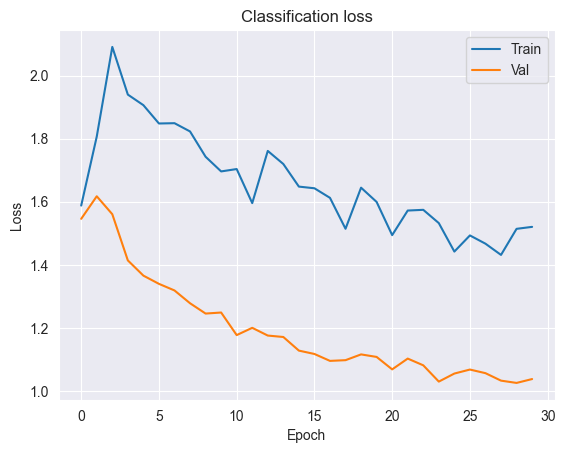

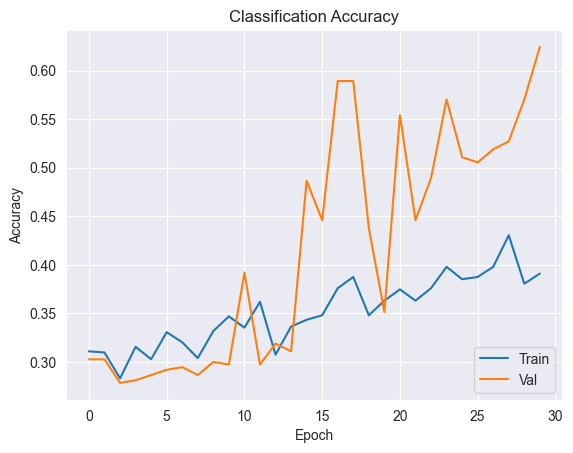

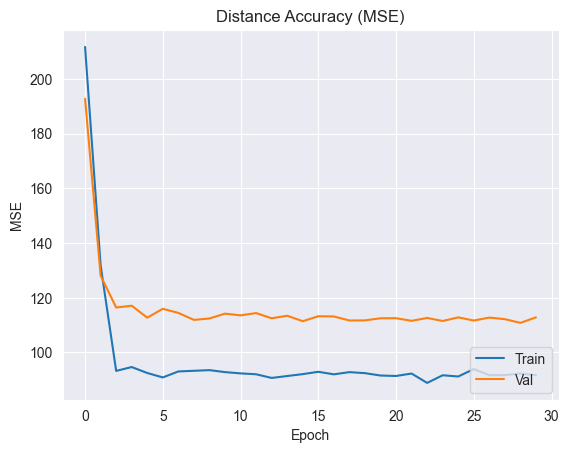

In [34]:

# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)  # Add dropout after the pooling layer
x = Flatten()(x)

# Add the Dense layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)  # Add dropout after the dense layer

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})
trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

# Model with less filters
This model has less filters in the convolutional layers. The model is trained for 60 epochs. The learning rate is set to 0.0002. The model is not overfitting and the loss is decreasing with training and is better than the previous models. It is almost and ideal model. While the lines dont quite converge it could be because of regularization and dropout layers.

Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - class_output_accuracy: 0.1830 - distance_output_mse: 246.6715 - loss: 248.9917 - val_class_output_accuracy: 0.1838 - val_distance_output_mse: 150.6963 - val_loss: 155.1226
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - class_output_accuracy: 0.1641 - distance_output_mse: 163.0970 - loss: 167.8034 - val_class_output_accuracy: 0.1676 - val_distance_output_mse: 135.7745 - val_loss: 140.2087
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - class_output_accuracy: 0.1886 - distance_output_mse: 124.5794 - loss: 128.4523 - val_class_output_accuracy: 0.2027 - val_distance_output_mse: 95.6914 - val_loss: 99.5015
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - class_output_accuracy: 0.1793 - distance_output_mse: 91.8391 - loss: 95.5599 - val_class_output_accuracy: 0.1676 - val_distance_output_mse: 87.4066 - val_loss: 90.9911
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - class_output_accuracy: 0.1966 - distance_output_mse: 

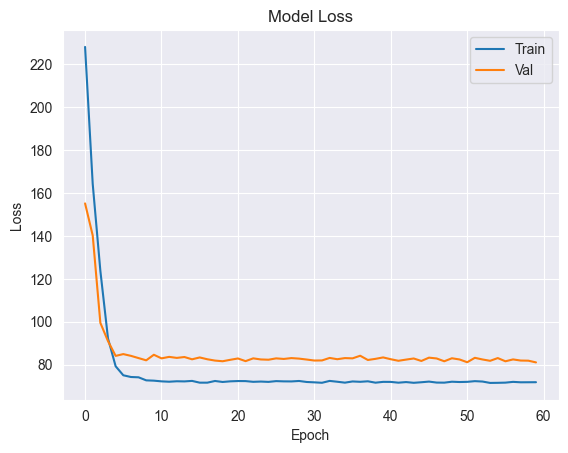

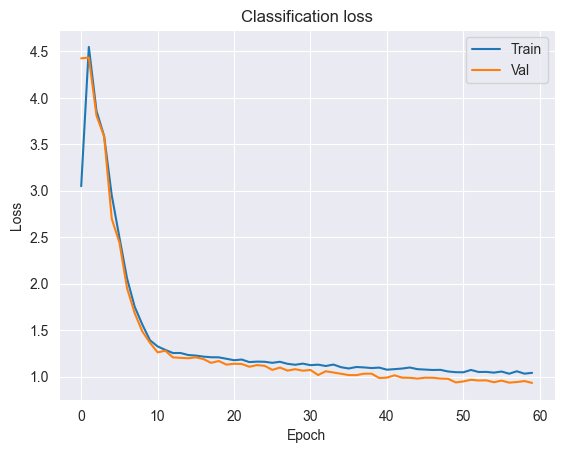

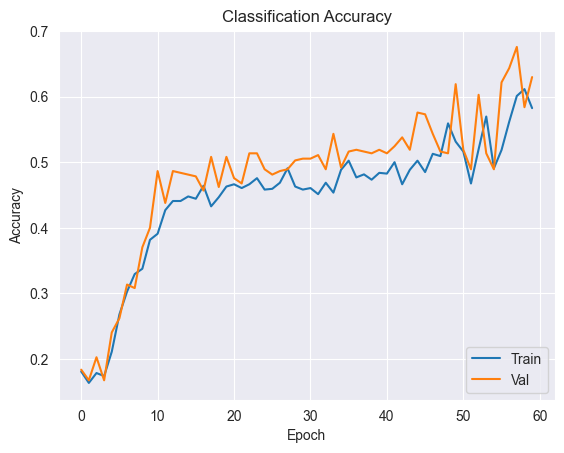

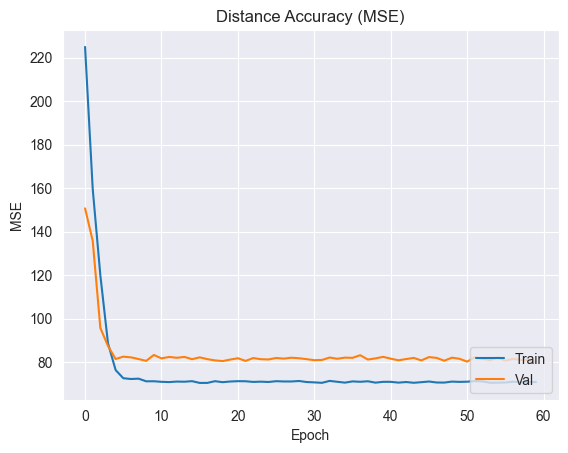

In [13]:

# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(16, (3,3), activation='relu')(input_layer)  # Reduced the number of filters from 32 to 16
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.1)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(32, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

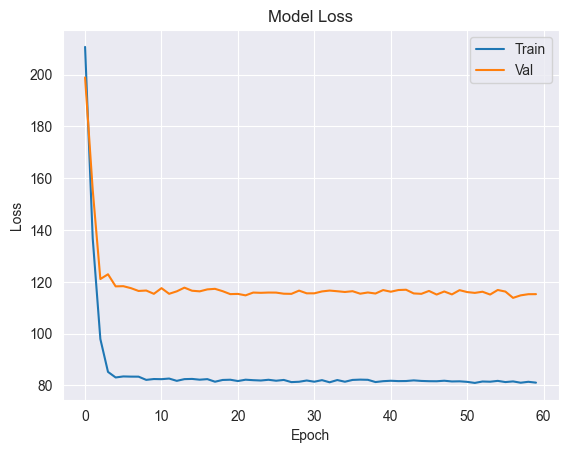

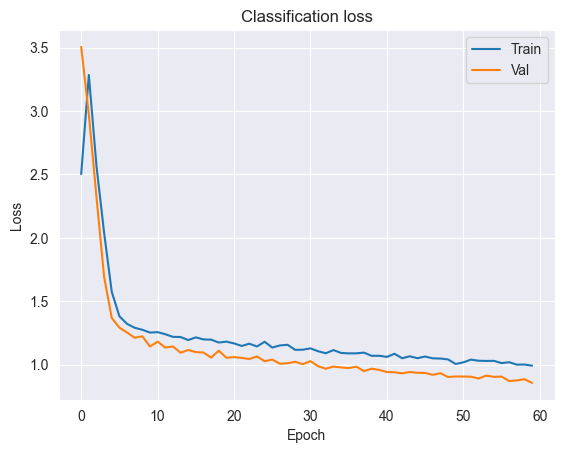

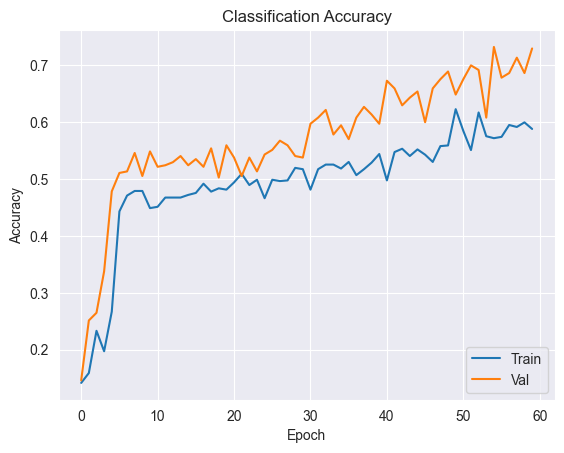

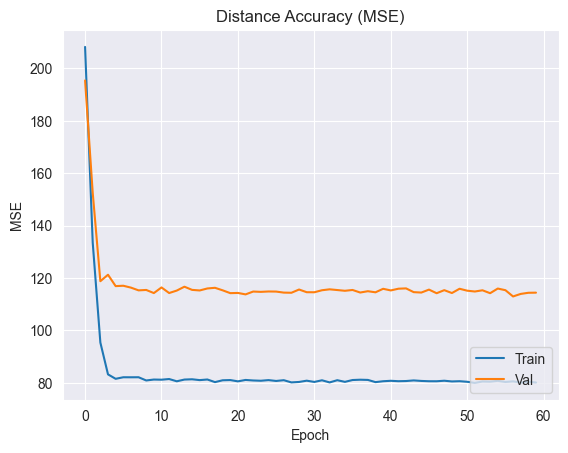

In [26]:

# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(16, (3,3), activation='relu')(input_layer)  # Reduced the number of filters from 32 to 16
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(32, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0003),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})
trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator),  # If using a separate test_generator
    verbose=0
)


plot_history(trained_model)

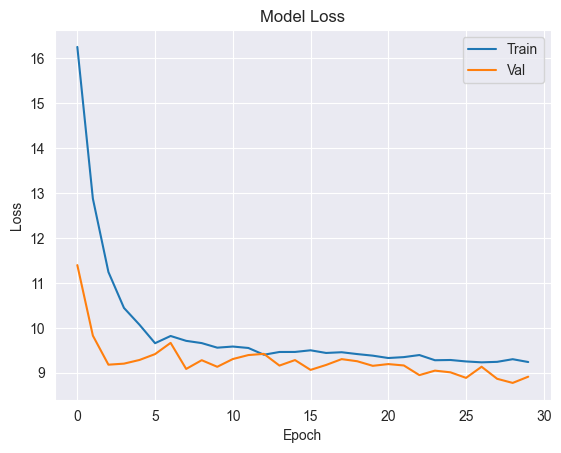

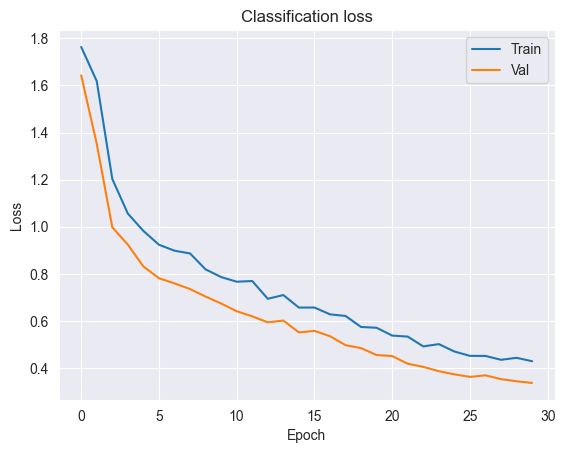

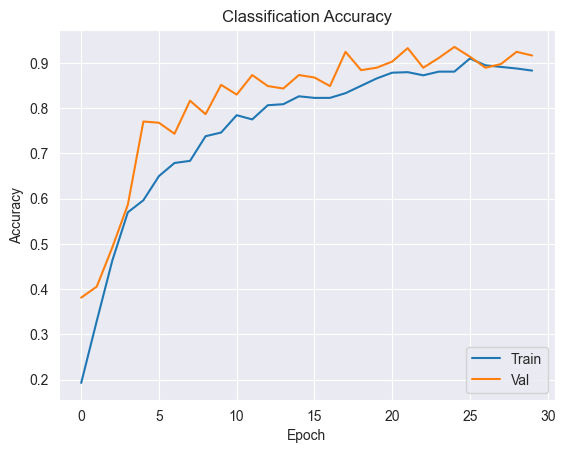

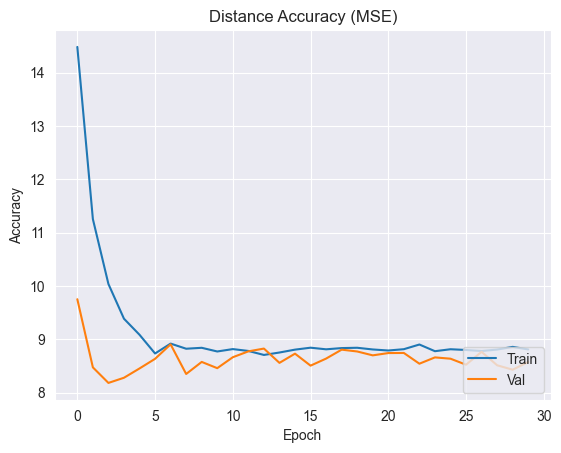

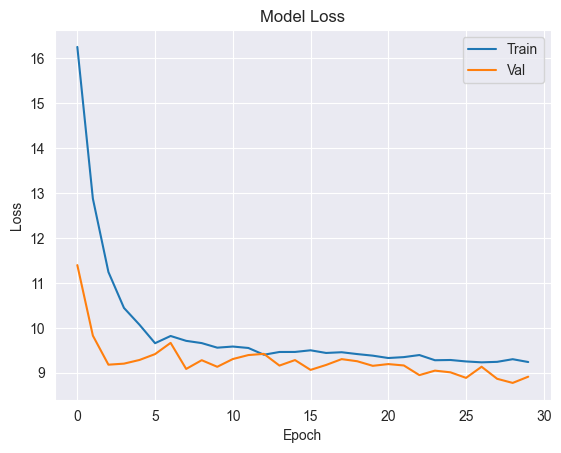

KeyError: 'distance_output_mse'

In [5]:
# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(16, (3,3), activation='relu')(input_layer)  # Reduced the number of filters from 32 to 16
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(32, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mae'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mae'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator) , # If using a separate test_generator
    verbose=0
)

plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(np.array(trained_model.history['loss'])-np.array(trained_model.history['distance_output_mae']))
plt.plot(np.array(trained_model.history['val_loss'])-np.array(trained_model.history['val_distance_output_mae']))
plt.title('Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(trained_model.history['class_output_accuracy'])
plt.plot(trained_model.history['val_class_output_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

plt.plot(trained_model.history['distance_output_mae'])
plt.plot(trained_model.history['val_distance_output_mae'])
plt.title('Distance Accuracy (MSE)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

plot_history(trained_model)

# Conclusion

No matter what configuration, model or hyper parameters the regression model never improves. The model is stuck at latest 150 which quite large for the magnitude we are working with (3-30). This is a huge concern. We have attempted to create a more complex model, this only worsens the CNN. At the same time the classification accuracy is fairly low and never achieves anything higher than 70%.


My suggestion is that the data is quite bad, there is not enough variation and maybe use a seperate model for the regression problem.